# Reducing and Filtering of Chord-Oddball data

In [1]:
import mne
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "../")
import ccs_eeg_utils
import numpy as np
import mne.preprocessing as prep
import os
import sklearn 
from contextlib import contextmanager
from autoreject import AutoReject

from mne_bids import (BIDSPath, read_raw_bids, write_raw_bids, inspect_dataset)

%matplotlib qt

# path where dataset is stored
bids_root = "./data/ds003570/"
TASK = 'AuditoryOddballChords'
SUBJECT = '014'
SUPRESS_BIDS_OUTPUT = True

In [2]:
# Context manager to suppress stdout and stderr
@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def read_raw_data(subject_id):
    bids_path = BIDSPath(subject=subject_id,
                         datatype='eeg', suffix='eeg', task=TASK,
                         root=bids_root)

    if SUPRESS_BIDS_OUTPUT:
        with suppress_stdout_stderr():
            raw = read_raw_bids(bids_path)
    else:
        raw = read_raw_bids(bids_path)

    # Inplace?
    ccs_eeg_utils.read_annotations_core(bids_path,raw)
    

    return raw


def preprocessing(raw, bad_channels = []):
    # TODO: bandpass first, downsample later? -> expensive!
    # 1. Downsampling to 64 Hz
    if raw.info['sfreq'] > 64:
        raw.resample(64)

    # Set channel types to EEG if not already set
    if not all(ch_type in ['eeg', 'stim'] for ch_type in raw.get_channel_types()):
        eeg_channel_names = raw.ch_names
        channel_types = {name: 'eeg' for name in eeg_channel_names}
        raw.set_channel_types(channel_types)

    # 2. Band-pass filter between 0.5 Hz and 30 Hz
    raw.filter(0.5, 30, fir_design='firwin')

    # 3. Re-referencing to the average activity of all electrodes
    #TODO: add apply_proj() here to apply arp?
    raw.set_eeg_reference('average', projection=True)

    """ events = prep.find_eog_events(raw)
    print(events) """

    # 4. Bad Channel Interpolations
    # Manually mark some channels as bad (all channels w/ n/a?)
    if bad_channels:
        raw.info['bads'] = bad_channels
    # Interpolate bad channels
    raw.interpolate_bads()

    # 5. Data Reduction (optional)
    # For instance, crop the first 60 seconds of the data

    return raw


def save_preprocessed_data(file_path, raw):
    """
    Saves the preprocessed EEG data to a file.

    Parameters:
    file_path (str): The path where the preprocessed data will be saved.
    raw (mne.io.Raw): The preprocessed MNE Raw object containing EEG data.
    """
    # Check if file_path ends with .fif extension
    if not file_path.endswith('.fif'):
        file_path += '.fif'

    # Save the data
    try:
        raw.save(file_path, overwrite=True)
        print(f"Data saved successfully to {file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

# see https://neuraldatascience.io/7-eeg/erp_artifacts.html
def run_ica(epochs):
    ar = AutoReject(n_interpolate=[1, 2, 4],random_state=42,picks=mne.pick_types(epochs.info, eeg=True,eog=True),n_jobs=-1, verbose=False)
    ar.fit(epochs)
    reject_log = ar.get_reject_log(epochs)

    fig, ax = plt.subplots(figsize=[15, 5])
    reject_log.plot('horizontal', ax=ax, aspect='auto')
    plt.show()

    ica = prep.ICA(n_components=2, random_state=42)
    ica.fit(epochs)
    print("ica")
    print(ica)
    ica.plot_components()


In [3]:
raw = read_raw_data(SUBJECT)

raw.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 misc
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 1024.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 5 items (dict)
>

Using matplotlib as 2D backend.


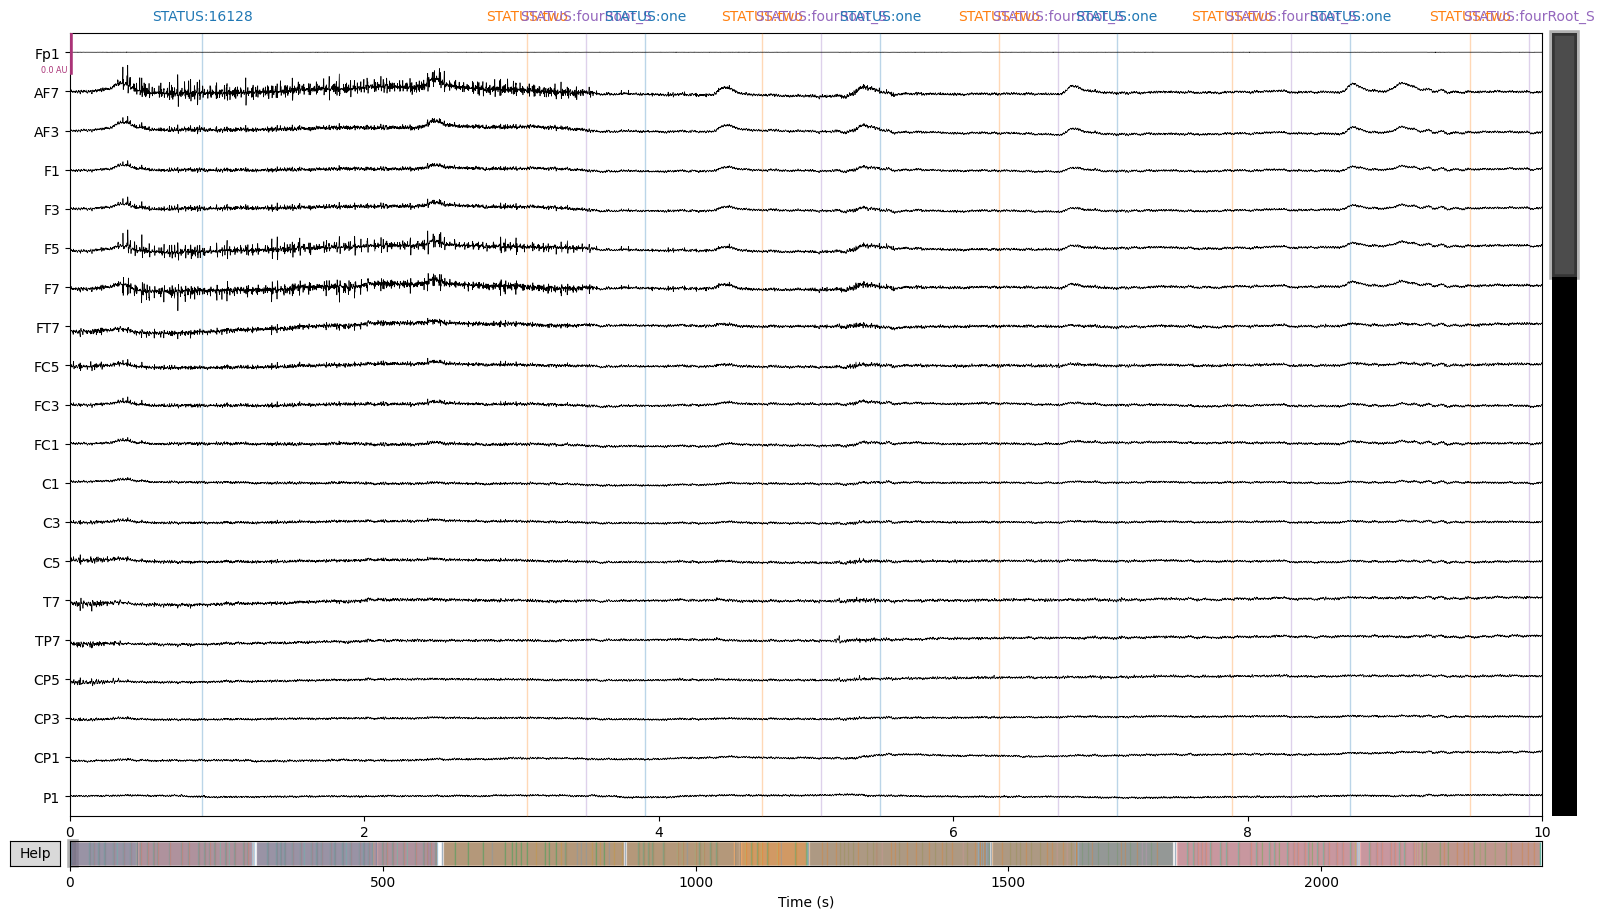

In [4]:
raw.plot()

In [5]:
# reduce bids eeg data
prep_raw = preprocessing(raw.copy())

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 31.00 Hz)
- Filter length: 423 samples (6.609 s)



C:\Users\mauff\AppData\Local\Temp\ipykernel_9504\227692323.py:43: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, Afz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types(channel_types)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


C:\Users\mauff\AppData\Local\Temp\ipykernel_9504\227692323.py:60: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [6]:
# save preprocessed data
#TODO: Care about naming conventions?
save_path = f'./data/processed_subject{SUBJECT}.fif'
save_preprocessed_data(save_path, prep_raw)

Overwriting existing file.
Writing d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif


C:\Users\mauff\AppData\Local\Temp\ipykernel_9504\227692323.py:82: RuntimeWarning: This filename (d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(file_path, overwrite=True)


Closing d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif
[done]
Data saved successfully to ./data/processed_subject014.fif


In [7]:
series = prep_raw[0,:]
#print(series[0][0])
plt.plot(series[0][0])
plt.show()
plt.plot(series[0][0])
plt.show()

## Epochs

In [8]:
# test with some electrode
raw_subselect = prep_raw.copy().pick(["Cz", "Pz", "Fz", "C4", "C3"])
raw_subselect.annotations

<Annotations | 4523 segments: STATUS:16128 (8), STATUS:Correct - Exemplar! ...>

In [12]:
# TODO: Copied from exercise 1, has to be adapted. Change selection of electrodes to electrodes near the ears? --> Cz is apparently connected to N2c
evts,evts_dict = mne.events_from_annotations(raw_subselect)

# not sure what annotations to use here
wanted_keys = [e for e in evts_dict.keys() if 'STATUS:five6_S' in e]

evts_dict_stim=dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

print(evts_dict_stim)



Used Annotations descriptions: ['STATUS:16128', 'STATUS:Correct - Exemplar!', 'STATUS:Correct - Function!', 'STATUS:Incorrect - Standard!', 'STATUS:boundary', 'STATUS:five6_S', 'STATUS:five6_deviantE', 'STATUS:five6_deviantEcorrect_E', 'STATUS:five6_deviantF', 'STATUS:five6_deviantFcorrect_F', 'STATUS:fiveRoot_S', 'STATUS:fiveRoot_deviantE', 'STATUS:fiveRoot_deviantEcorrect_E', 'STATUS:fiveRoot_deviantF', 'STATUS:fiveRoot_deviantFcorrect_F', 'STATUS:four6_S', 'STATUS:four6_Sincorrect', 'STATUS:four6_deviantE', 'STATUS:four6_deviantEcorrect_E', 'STATUS:four6_deviantF', 'STATUS:four6_deviantFcorrect_F', 'STATUS:fourRoot_S', 'STATUS:fourRoot_Sincorrect', 'STATUS:fourRoot_deviantE', 'STATUS:fourRoot_deviantEcorrect_E', 'STATUS:fourRoot_deviantF', 'STATUS:fourRoot_deviantFcorrect_F', 'STATUS:one', 'STATUS:two']
{'STATUS:five6_S': 6}


In [15]:

# TODO: does not work yet, just copied and adapted the epoch timeframe
# 400 ms before stimulus onset, 1600 ms after stimulus onset - Stimulus 2 --> since each chord lasts 400ms --> 0s - 2000
# maybe add baseline=(0.3,0.4) according to paper --> then no ica though
raw_subselect.info.normalize_proj()
epochs = mne.Epochs(raw_subselect,evts,evts_dict_stim,tmin=-0.4,tmax=1.6,baseline=None,preload=True)

#TODO: fix ICA - Warum da fuck hab ich da Kuchendiagramme?!
run_ica(epochs)

# extract data from epochs object
data = epochs.get_data()
times = epochs.times

n_trials = 3 # use data.shape[0] for all
fig, axs = plt.subplots(n_trials, 1, figsize=(10, 3*n_trials), sharex=True, sharey=True)

# plot selected trials
for i in range(n_trials):
    for ch in range(data.shape[1]):
        axs[i].plot(times, data[i, ch, :], label=f'Channel {ch}')
    axs[i].set_title(f'Trial {i}')
    axs[i].legend(loc='upper right')

# label the x-axis
plt.xlabel('Time (s)')

# display the plot
plt.show()



Not setting metadata
305 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 305 events and 129 original time points ...


0 bad epochs dropped
Fitting ICA to data using 5 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 2 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 0.0s.
ica
<ICA | epochs decomposition, method: fastica (fit in 4 iterations on 39345 samples), 2 ICA components (5 PCA components available), channel types: eeg, no sources marked for exclusion>
